In [1]:
import numpy as np
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import math

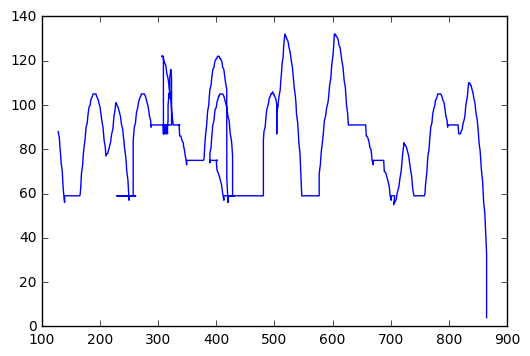

In [2]:
all_tracks = pickle.load(open('all_tracks.pkl'))


for track in all_tracks:
    if track[0] == 'track1':
        dat  = [track[1][t][0] for t in sorted(track[1])]
        break
        
dat = np.array(dat)
plt.plot(dat[:,0],dat[:,1])
plt.show()


In [3]:
track = dat


In [4]:
def jumps(vals):
    
    return [t for t in range(1,len(vals)) if  np.abs(vals[t]-vals[t-1]) > 1]

def samey_intervals(vals, t_window=5):
    last = vals[0]
    start = -1
    accum = 0
    intervals = []
    
    for t, v in enumerate(vals):
        
        if v == last:
            accum += 1            
        else:
            if accum > t_window:
                intervals.append(t-1)
                intervals.append(t)
                intervals.append(t+1)
                intervals.append(t-accum-1)
                intervals.append(t-accum)
                intervals.append(t-accum+1)
            accum = 0

        last = v
    return intervals


def zero_crossings(vals):    

    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]    
    zeros = np.zeros(vsigns.shape)
    zeros[vsigns == 0] = 1
    accum = 0

    for t in range(len(zeros)):        
        if zeros[t] == 1:
            accum += 1
        else:
            accum = 0
        zeros[t] = accum
    last = 0

    for t,v in enumerate(zeros):
        if v == 1:
            sign_intervals.append(t)
            sign_intervals.append(t-1)
        elif v == 0 and last > 5:
            sign_intervals.append(t)
            sign_intervals.append(t-1)
        last = v

    return sorted(set(sign_intervals))

In [5]:
velocities = track[1:,1]-track[:-1,1]
all_times = range(len(velocities))

plt.plot(track[:,1])

same_window = 6

switch_points = set(zero_crossings(velocities))

samey_points = set(samey_intervals(velocities,t_window=same_window))


def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    # Note: for a temporary optimization we could drop certain buttons?
    for t,b in enumerate(button_masks):
        if b != last_mask:
            mask_times.append(t)
            last_mask = b
    return mask_times
input1,input2 = pickle.load(open('inputs.pkl'))


In [6]:
print input1


[128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 129L, 0L, 0L, 0L, 0L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 64L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 128L, 

In [7]:
button_times = set(button_change_times(input1)) | set(button_change_times(input2))

In [8]:
velocity_times = switch_points | samey_points | set(jumps(velocities))


all_times = sorted(button_times | velocity_times) + [len(velocities)-1]
print all_times

[0, 8, 9, 10, 11, 28, 29, 30, 46, 47, 61, 64, 65, 76, 77, 85, 95, 96, 97, 98, 102, 106, 129, 151, 219, 220, 221, 237, 238, 251, 252, 253, 254, 279, 297, 298, 299, 304, 305, 307, 309, 310, 312, 313, 315, 316, 317, 318, 319, 321, 322, 324, 325, 326, 327, 328, 330, 331, 332, 333, 334, 335, 336, 347, 348, 351, 355, 366, 367, 368, 369, 375, 376, 377, 386, 387, 388, 389, 393, 408, 409, 410, 413, 425, 426, 427, 428, 430, 431, 439, 440, 450, 452, 453, 454, 455, 458, 464, 465, 466, 470, 482, 483, 487, 488, 489, 498, 500, 501, 502, 503, 504, 516, 517, 518, 527, 528, 529, 530, 582, 583, 584, 587, 591, 599, 600, 602, 603, 608, 613, 614, 615, 623, 630, 631, 632, 634, 635, 649, 657, 658, 659, 660, 684, 685, 686, 707, 708, 713, 714, 718, 730, 731, 732, 733, 754, 755, 756, 765, 766, 767, 768, 779, 780, 781, 790, 791, 793, 794, 795, 796, 808, 809, 820, 821, 822, 823, 828, 835, 836, 837, 853, 854, 859, 867, 868, 869, 870, 881, 882, 883, 895, 896, 897, 898, 922, 923, 924, 925, 929, 949, 954, 930]


In [9]:
'''def make_inputs(start,end,input_type):
    end = all_times[end]
    start = all_times[start]
    interval = end-start
    data = np.zeros((interval,1))
    
    vels =14 np.copy(velocities[start:end])
    if input_type in ['cN','accN']:
        data = np.hstack((data,np.ones((interval,1))))
    if input_type in ['acc0','accP','accN']:
        dat = np.ones((interval,1))
        for ii in range(interval):
            dat[ii,0] = ii
            
        data = np.hstack((data,dat))
    if input_type in ['accP','cP']:
        begin = velocities[start-1]
        vels -= begin
    return data, vels
'''
def make_inputs(start,end,input_type):
    end = all_times[end]
    start = all_times[start]
    interval = end-start
    
    if input_type in ['c0']:
        data = np.zeros((interval,1))
    elif input_type in ['acc0']:
        dat = np.ones((interval,1))
        for ii in range(interval):
            dat[ii,0] = ii
        data = dat
    else:
        data = np.ones((interval,1))
    
    vels = np.copy(velocities[start:end])
    if input_type in ['accP','accN']:
        dat = np.ones((interval,1))
        for ii in range(interval):
            dat[ii,0] = ii
            
        data = np.hstack((data,dat))
    return data, vels

[0, 8, 9, 10, 11, 28, 29, 30, 46, 47, 61, 64, 65, 76, 77, 85, 95, 96, 97, 98, 102, 106, 129, 151, 219, 220, 221, 237, 238, 251, 252, 253, 254, 279, 297, 298, 299, 304, 305, 307, 309, 310, 312, 313, 315, 316, 317, 318, 319, 321, 322, 324, 325, 326, 327, 328, 330, 331, 332, 333, 334, 335, 336, 347, 348, 351, 355, 366, 367, 368, 369, 375, 376, 377, 386, 387, 388, 389, 393, 408, 409, 410, 413, 425, 426, 427, 428, 430, 431, 439, 440, 450, 452, 453, 454, 455, 458, 464, 465, 466, 470, 482, 483, 487, 488, 489, 498, 500, 501, 502, 503, 504, 516, 517, 518, 527, 528, 529, 530, 582, 583, 584, 587, 591, 599, 600, 602, 603, 608, 613, 614, 615, 623, 630, 631, 632, 634, 635, 649, 657, 658, 659, 660, 684, 685, 686, 707, 708, 713, 714, 718, 730, 731, 732, 733, 754, 755, 756, 765, 766, 767, 768, 779, 780, 781, 790, 791, 793, 794, 795, 796, 808, 809, 820, 821, 822, 823, 828, 835, 836, 837, 853, 854, 859, 867, 868, 869, 870, 881, 882, 883, 895, 896, 897, 898, 922, 923, 924, 925, 929, 930]
Points: 201
[0, 8

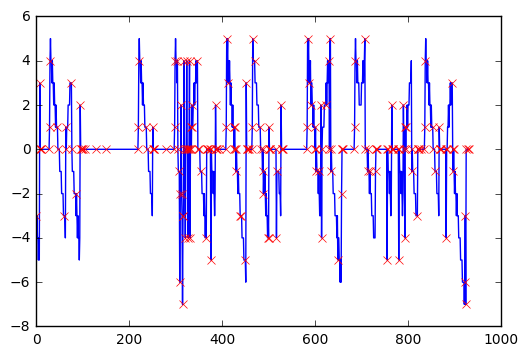

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [18]:
%matplotlib inline 
import statsmodels.api as sm

all_times = [t for t in all_times if (t >= 0 and t < len(velocities))]
print all_times
likes = [None]*len(all_times)

print "Points:",len(all_times)
print all_times
plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4
max_interval = all_times[-1]-all_times[0]

likes = [None]*len(all_times)
for i in range(0,len(all_times)):
    print i
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval and  all_times[j]-all_times[i] < max_interval]:
        models = {}
        if all_times[j]-all_times[i] >= min_interval:
            for model in ['c0','cN','acc0','accN']:
                X,Y = make_inputs(i,j,model)
                ols = sm.OLS(Y,X,hasconst=False)
                results = ols.fit()
                models[model] = results
        likes[i][j] = models

#print ''

In [19]:
from scipy import stats

inp = []
def penalty(length,params):
    penalty_type = 'MDL' # 'BIC'
    if penalty_type == 'MDL':
        return 2*(1.0 + 0.5*np.log(length))*(params)
    if penalty_type == 'BIC':
        return 2*np.log(length)*(params)

In [20]:
%%time
modes = [(0,None)]*(len(all_times))
        
model_type_params = {'c0':0,
                    'cN':1,
                    'acc0':1,
                    'accN':2}

for m in model_type_params:
    model_type_params[m] += np.ceil(np.log2(len(model_type_params)))
    print m,model_type_params[m]
str_out = ''
regularization = 1

def score_model(length,model,model_type):
    crit = -model.model.loglike(model.params)
    if crit == -float('inf') or crit < 0:
        crit = -33*length #-2000*(length+1) #2000*log(0.1^2)-1/(2*0.1^2)
        
    cost = regularization*penalty(length,model_type_params[model_type])#penalty(all_times[-1]-all_times[0],model.params)
    return crit +  cost, crit,cost
                

print len(all_times)
for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    for i in range(0, j):
        data = likes[i][j]
        if data:
            for model_type,model in data.items():
                    
                m_prev = modes[i][0]
                here,crit,cost = score_model(all_times[j]-all_times[i],model,model_type)
                
                here += m_prev 
                
                str_out += '{}, {}, {},  {}, {}, {}, {}\n'.format(all_times[i], all_times[j], crit, cost,here,least,model_type)
                if here < least:
                    
                    
                    least = here
                    # prev_i,this_j,t0,t1,name,summary,criterion
                    least_template = (i,j,(model_type,model,crit))
    
                   
    modes[j] = (least, least_template)
with open('temp.txt','wb') as outfile:
    outfile.write(str_out)

accN 4.0
c0 2.0
cN 3.0
acc0 3.0
201
CPU times: user 5.45 s, sys: 4 ms, total: 5.45 s
Wall time: 5.45 s


In [21]:
%matplotlib notebook
def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)

models = {}

for ii, p in enumerate(path):
    current_model_type = p[1][2][0]
    current_model_params = p[1][2][1].params
    key = 0
    can_merge = p[1][2][2] < 0
        
    found_match = False
    if can_merge:
        for m in models:
            if m[0] == current_model_type and m[3]:
                diff = np.sum(np.power(np.array(m[1]) - p[1][2][1].params,2.0))
                if diff < 1e-6:
                    found_match = True
                    models[m].append(ii)
                    break
    if not found_match:
        if can_merge:
            current_key = (current_model_type,tuple(current_model_params),0,can_merge)
        else:
            current_key = (current_model_type,tuple(current_model_params),ii,can_merge)
        if current_key not in models:
            models[current_key] = []
        models[current_key].append(ii)

        
model2index = {m:i for i,m in enumerate(sorted(models))}
index2model = {i:m for i,m in enumerate(sorted(models))}


path2index = {}

for m in sorted(models):
    print m, models[m]
    for ii in models[m]:
        path2index[ii] = model2index[m] 
initial_segmentation = [path2index[ii]  for ii,p in enumerate(path)]
    
print initial_segmentation
       


data = []
for ii,p in enumerate(path):
    data.append([all_times[p[1][0]],ii*0.1+6])
    data.append([all_times[p[1][1]],ii*0.1+6])
    print ii,p[0],'\n',all_times[p[1][0]],all_times[p[1][1]],p[1][2][1].params,'\n'
    
#data = np.array(data)    
#plt.plot(velocities[:all_times[-1]])
#plt.plot(data[:,0],data[:,1])
#plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
#plt.show()
    

('acc0', (-0.28769230769230769,), 34, False) [34]
('acc0', (-0.27941176470588236,), 28, False) [28]
('acc0', (-0.27619047619047621,), 4, False) [4]
('acc0', (-0.25071298936997666,), 39, False) [39]
('acc0', (-0.24884366327474572,), 24, False) [24]
('acc0', (-0.19393077287814128,), 11, False) [11]
('acc0', (0.012096774193548385,), 0, True) [35]
('acc0', (0.21114982578397212,), 23, False) [23]
('acc0', (0.25396825396825395,), 38, False) [38]
('acc0', (0.282258064516129,), 10, False) [10]
('acc0', (0.28769230769230769,), 3, False) [3]
('acc0', (0.29059829059829057,), 33, False) [33]
('accN', (-0.12087912087912091, 0.032967032967032975), 0, True) [17]
('accN', (0.22794117647058826, -0.022058823529411752), 0, True) [19]
('accN', (0.24166666666666667, -0.024999999999999994), 0, True) [37]
('accN', (4.6129032258064511, -0.24916573971078976), 36, False) [36]
('accN', (4.616806722689077, -0.24950343773873188), 2, False) [2]
('accN', (4.6193548387096772, -0.24961067853170188), 6, False) [6]
('ac

In [22]:
import random
def mutate(segmentation):    
    mutated = list(segmentation)
    if random.random() < 0.15:
        mutated[random.randint(0,len(segmentation)-1)] = random.randint(0,len(segmentation)-1)
    else:
        possibles = set(segmentation)
        old = random.choice(list(possibles))
        new = old
        while new == old:
            new = random.choice(list(possibles))
        for ii in range(len(segmentation)):
            if mutated[ii] == old:
                mutated[ii] = new
                
        
    return mutated
def crossover(seg1,seg2):
    crossover_point = random.randint(1,len(seg1)-2)
    return seg1[:crossover_point] + seg2[crossover_point:]



def find_best_model(merge,debug=False):
    best_score = float('inf')
    best_model = None
    best_type = None
    for model in ['c0','cN','acc0','accN']:
        merged_X  = []
        merged_Y  = []
        for index in merge:
            seg = path[index]

            X,Y = make_inputs(seg[1][0],seg[1][1],model)
            merged_X.append(X)
            merged_Y.append(Y.reshape(-1,1))
        if len(merged_X) > 1: 
            merged_X = reduce(lambda x,y: np.vstack((x,y)),merged_X)
            merged_Y = reduce(lambda x,y: np.vstack((x,y)),merged_Y)
        else:
            merged_X = merged_X[0]
            merged_Y = merged_Y[0]
        ols = sm.OLS(merged_Y,merged_X,hasconst=False)
        results = ols.fit()

        scored_model, crit,cost = score_model(len(merged_Y),results,model)
        if debug:
            print model,scored_model,results.params, crit,cost,len(merged_Y)
        if scored_model < best_score:
            best_score = scored_model
            best_model = results
            best_type = model
    return best_score,best_model,best_type
def score(segmentation):
    merged = {}
    for index,segment in enumerate(segmentation):
        if segment not in merged:
            merged[segment] = []
        merged[segment].append(index)
    sum_of_scores = 0
    for merge in merged:         
        best_score, _, _ = find_best_model(merged[merge])
        sum_of_scores += best_score
    return sum_of_scores

In [23]:
population = []
population_size = 200

for ii in range(population_size):    
    population.append(list(initial_segmentation))
    if ii > population_size*0.5:
        for jj in range(4):
            population[-1] = mutate(population[-1])
            

In [25]:
'''
#Wanted to make sure this actually worked
to_merge = [0,7,10,13,18,21,24,34,38,40,43,47]
member = list(range(len(path)))
for ii in range(len(member)):
    if ii in to_merge:
        member[ii] = 0
print score(member)
print score(list(range(len(path))))
'''
generations=  100

selection_probability = 0.01
keep = 10
            
crossover_count = 15
for generation in range(generations):
    print generation
    scored = {}
    for ii,member in enumerate(population):
        member_score = score(member)
        if member_score not in scored:
            scored[member_score] = []
        scored[member_score].append(member)
    
    ranked = []
    print sorted(scored)[0]
    for s in sorted(scored):
        ranked += scored[s]
    
    new_population = []
    for ii in range(keep):
        for member in ranked:
            if random.random() < selection_probability:
                new_population.append(member)
                break
    
        
    
    while len(new_population) != population_size:
        new_population.append(mutate(random.choice(new_population)))
        
    population = new_population
    
    
    

0
-13120.7906717
1
-13120.7906717


KeyboardInterrupt: 

7
c0 321.70196054 [ 0.] 308.126977055 13.5749834856 120
cN 255.084028202 [-2.65] 234.721552974 20.3624752283 120
acc0 154.193672689 [-0.24986171] 133.831197461 20.3624752283 120
accN 156.599714857 [-0.34960056 -0.2262688 ] 129.449747886 27.1499669711 120
4 acc0 [-0.24986171]

c0 200.226175721 [ 0.] 187.412737226 12.8134384945 82
cN 206.5940835 [-0.07317073] 187.373925759 19.2201577418 82
acc0 202.270411088 [ 0.0909412] 183.050253347 19.2201577418 82
accN 195.053420377 [-2.08174958  0.29569742] 169.426543388 25.6268769891 82
5 accN [-2.08174958  0.29569742]

c0 108.682935448 [ 0.] 97.1605352166 11.5224002314 43
cN 83.5807254384 [ 2.02325581] 66.2971250913 17.2836003471 43
acc0 45.3435581677 [ 0.28608343] 28.0599578206 17.2836003471 43
accN 47.2198870734 [ 0.35515379  0.24819511] 24.1750866106 23.0448004628 43
3 acc0 [ 0.28608343]

c0 -13843.9194906 [ 0.] -13860 16.0805094226 420
cN -13835.8792359 [ 0.02857143] -13860 24.1207641338 420
acc0 -13835.8792359 [ 0.00041661] -13860 24.12076413

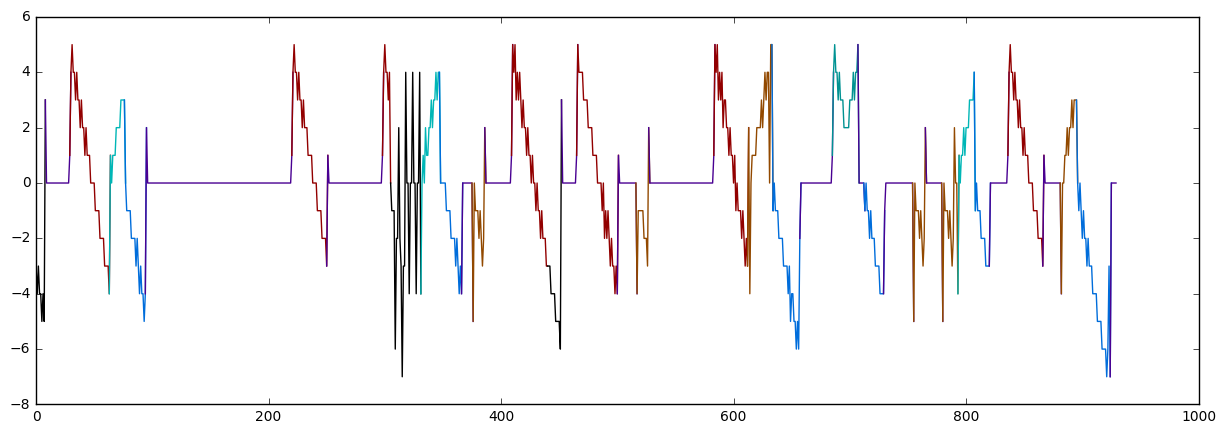

"\nplt.figure(figsize=(15,5))\nplt.plot(velocities[:all_times[-1]])\nplt.plot(mode_assignment[:,0],mode_assignment[:,1])\nplt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')\nplt.show()\n"

In [26]:

%matplotlib inline
best = ranked[0]
if False:
    #-242000  -- 35
    best = [0, 1, 2, 3, 4, 5, 4, 6, 2, 0, 1, 2, 0, 1, 2, 0, 1,
            0, 4, 0, 7, 0, 1, 2, 0, 1, 2, 8, 0, 1, 2, 9, 4, 0, 1, 
            0, 1, 2, 10, 7, 9, 0, 1, 0, 7, 0, 1, 2, 10, 4, 0, 1, 4, 0]
    
m2i = {m:i for i, m in enumerate(sorted(set(best)))}
print len(m2i)

best = [m2i[b] for b in best]


mode_assignment = []

assigned = {}
colors = ['#000000','#490092','#920000',
          '#00b6b6','#006ddb','#924900',
          '#009292','#b66dff','#dbd100',
          '#ff6db6','#6db6ff','#24ff24',
          '#ffb677','#b6dbff','#ffff6d',]
prev_mode = 0
plt.figure(figsize=(15,5))
for p,b in zip(path,best):
    if b not in assigned:
        assigned[b] = len(assigned)
        
merged = {}
for index,segment in enumerate(best):
    if segment not in merged:
        merged[segment] = []
    merged[segment].append(index)
    

merged_models = {}
for merge in merged:         
    
    _ , best_model, best_type = find_best_model(merged[merge],debug=True)
    merged_models[assigned[merge]] = (best_model.params, best_type)
    print assigned[merge],best_type, best_model.params
    print ''



merged_trace = []
for p,b in zip(path,best):
    
    mode_assignment.append((all_times[p[1][0]],assigned[b]+7))
    mode_assignment.append((all_times[p[1][1]],assigned[b]+7))
    
        
    start_t = all_times[p[1][0]]
    end_t = all_times[p[1][1]]
    merged_trace.append((start_t,end_t, assigned[b], merged_models[assigned[b]]))
    if assigned[b] != 0:
        start_t = all_times[p[1][0]]-1
        if start_t < 0:
            start_t = 0        
        end_t = all_times[p[1][1]]+1
        if end_t >= len(velocities):
            end_t = len(velocities) -1
        
    t = np.array(range(start_t,end_t))
    
    v = velocities[start_t:end_t]
    plt.plot(t,v,colors[assigned[b]])
    
    
    
    prev_mode = assigned[b]
    
pickle.dump((merged_trace,merged_models),open('merged_trace.pkl','wb'))
plt.show()
mode_assignment = np.array(mode_assignment)

'''
plt.figure(figsize=(15,5))
plt.plot(velocities[:all_times[-1]])
plt.plot(mode_assignment[:,0],mode_assignment[:,1])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()
'''

